<a href="https://colab.research.google.com/github/eruru0411/git-test/blob/master/Food_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# train
# 변수                          정의

# ID       	                   고유 ID
# 주                             주 번호
# center_id                    이행 센터의 고유 ID
# meal_id                      식사의 고유 ID
# 체크 아웃_가격 할인,     세금 및 배송비를 포함한 최종 가격 기준_가격 기준 식사 가격
# e-mailer_for_promotion 식사 홍보를 위해 보낸 전자 메일러
# 홈페이지 특집 식사       홈페이지에 소개된 식사
# num_orders(대상)         주문 수- target


# fulfilment_center_info.csv
# 변수            정의
# center_id       이행 센터의 고유 ID
# city_code       도시의 고유 코드
# region_code     지역에 대한 고유 코드
# center type     익명 센터 유형
# op_area         작동 영역(km^2)


# meal_info.csv
# 변수             정의
# meal_id         식사의 고유 ID
# category        식사 유형(음료/과자/국...)
# cuisine(요리)   식사 요리(인도/이탈리아/…)

In [ ]:
# 1. EDA  : 데이터 사전 탐색
#    0) Dataframe 살펴보기
#    1) 차트그리기
# 2. 결측치/이상치 --> 처리
# 3. 피쳐 전처리/가공
# 4. 학습/평가 : f1, auc
# 5. 검증(GridSearchCV, confusion_matrix)

import pandas  as pd
import numpy   as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy            import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import confusion_matrix, accuracy_score, f1_score, roc_auc_score,\
                             precision_score,recall_score, roc_curve, classification_report,precision_recall_curve
from sklearn                 import preprocessing
from sklearn.preprocessing   import StandardScaler,RobustScaler,MinMaxScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold
import warnings
warnings.filterwarnings(action="ignore")
barline = "\n============================================"
e = "\n"

# Dataframe 확인 ---------------------------------------
def MyCheckDataframe(df, target="target") :
    print("Check Dataframe ----------------------------")
    print("Shape :", e, df.shape)
    print("Info  :", e, df.info())
    print("Head  :", e, df.head())
    print("Count :", e, df[target].value_counts())

    y = df[target]
    X = df.drop(target, axis=1)
    print("Target Shape :", e, X.shape, y.shape, barline)
    return X, y
# X,y = CHECK_DATAFRAME(df, target="")


# -------------------------------------
# 4-2. IQR : 25%~75% 범위 값
# -------------------------------------
def MyCheckOutlier(df=None, column=None, print=None):
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    for k, v in df.items():
        Q1 = v.quantile(0.25)
        Q3 = v.quantile(0.75)
        IQR = Q3 - Q1
        IQR_weight = IQR * 1.5
        minimum = Q1 - IQR_weight
        maximum = Q3 + IQR_weight
        outlier_idx = v[(v < minimum) | (v> maximum)].index

        if print == True:
            perc = np.shape(outlier_idx)[0] * 100.0 / np.shape(df)[0]
            print("Column %s outliers = %.2f%%" % (k, perc))

    print(barline)
    return outlier_idx
    # Q1  = np.percentile(df[column].values, 25)
    # Q3  = np.percentile(df[column].values, 75)
    # IQR = Q3 - Q1
    # IQR_weight  = IQR * 1.5
    # minimum     = Q1 - IQR_weight
    # maximum     = Q3 + IQR_weight
    # outlier_idx = df[column][  (df[column] < minimum) | (df[column] > maximum)  ].index

# outlier_idx = CHECK_OUTLIER(df=df, column=col)
# print(col, oulier_idx)
# df.drop(outlier_idx, axis=0, inplace=True)
    #---------------------------------------------
    # numeric_columns = df.dtypes[df.dtypes != 'object'].index
    # for i, col in enumerate(numeric_columns) :
    #     oulier_idx = CHECK_OUTLIER(df=df, column=col)
    #     print(col , oulier_idx)
    #     #df.drop(outlier_idx, axis=0, inplace=True)


def MyCheckZeros(X):
    print("Check Zeros --------------------------------")
    for col in X.columns:
        gcnt = X[col][X[col] == 0].count()
        print(col, ":", gcnt, "(", np.round(gcnt / X.shape[0] * 100, 2), ")")
    print(barline)

def MyCheckNull(X):
    print("Check Null ---------------------------------")
    # print(df.isnull().sum())
    for col in X.columns:
        gcnt = X[col][X[col] == np.nan].count()
        print(col, ":", gcnt, "(", np.round(gcnt / X.shape[0] * 100, 2), ")")
    print(barline)

def MyScores(y_test, pred, proba, str=None) :
    print("Scores : {} ---------" .format(str))
    acc       = accuracy_score(y_test, pred)
    f1        = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall    = recall_score(y_test, pred)
    auc       = roc_auc_score(y_test, proba[:, 1].reshape(-1, 1))
    print("정확도{:.4f}  F1 {:.4f}=(정밀도{:.4f} 재현률{:.4f}) auc {:.4f}" .format(acc, f1, precision, recall, auc))
    cf_matrix = confusion_matrix(y_test, pred)
    print("Confusion Matrix", e, cf_matrix, barline)


def MySplitFitPredict(model, X, y, str=None, rate=0.2, prc=False, roc=False) :
    X_train ,X_test , y_train, y_test = train_test_split(X, y, test_size=rate, random_state=121)
    model.fit(X_train, y_train)
    pred  = model.predict(X_test)
    proba = model.predict_proba(X_test)

    MyScores(y_test, pred, proba, str)

    if prc == True:
        MyChartPrcRclCurve(y_test, proba)
    if roc == True:
        MyChartRocCurve(y_test, proba)
    return proba # X_train, X_test, y_train, y_test, proba # , pred, proba
# rf_model = RandomForestClassifier()
# SPLIT_FIT_PREDICT(rf_model, X, y, str="최초점수", 0.5)
# SPLIT_FIT_PREDICT(rf_model, X, y)


def MyChartHeatmap(df, targetClass=None, topn=0):
    plt.figure(figsize=(10,6))
    if   topn > 0 :
        idx = df.corr().nlargest(topn, targetClass).index
        print("Correlation: Top", topn, e, idx, barline)
        sns.heatmap(df[idx].corr(), annot=True, fmt=".2g", cmap="Blues")
    elif topn < 0 :
        idx = df.corr().nsmallest(-1 * topn, targetClass).index
        print("Correlation: Bottom", -topn, e, idx, barline)
        sns.heatmap(df[idx].corr(), annot=True, fmt=".2g", cmap="Blues")
        # cols = ['V12', 'V14', 'V10', 'V17', 'V3','Class']
        # sns.heatmap(df[cols].corr(), annot=True, fmt=".2g", cmap="Blues")
    else :
        sns.heatmap(df.corr(), annot=True, fmt=".2g", cmap="Blues")
    plt.show()
# CHART_HEATMAP(df, 5)
# CHART_HEATMAP(df, -5)
# CHART_HEATMAP(df)

def MyCrossValidate(model, X, y, cv=5) :
    print("Cross Validation ---------------------------")
    my_score   = {"acc":"accuracy", "f1":"f1"}
    score_list = cross_validate(model, X, y, scoring=my_score, cv=5, verbose=0)
    score_df   = pd.DataFrame(score_list)
    print("cross_validation 평균 정확도 : " , score_df["test_acc"].mean())
    print("cross_validation 평균 f1    : "    , score_df["test_f1"].mean())
    print(barline)
# CROSS_VALIDATION(model, X, y)

def MyGridSearchCV(my_hyper_param, model, X, y) :
    print("GridSerchCV --------------------------------")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121)
    my_score  = {"acc": "accuracy", "f1": "f1"}
    gcv_model = GridSearchCV(model, param_grid=my_hyper_param, scoring=my_score, refit="f1", cv=5, verbose=0)
    gcv_model.fit(X_train, y_train)

    # print("best_estimator:", gcv_model.best_estimator_)
    print("best_params :", gcv_model.best_params_)
    print("best_score  :", gcv_model.best_score_)
    print("GridSearchCV 평균 정확도 : ", gcv_model.cv_results_["mean_test_acc"].mean())  #mean_test_(본인의score키값)
    print("GridSearchCV 평균 F1    : ", gcv_model.cv_results_["mean_test_f1"].mean())
    print(barline)
# my_hyper_param = {  "n_estimators"     :[100]}
# GRIDSEARCHCV(my_hyper_param, model, X_train, y_train)


def MyGroupFillNa(bycol, cols, tcol):
    dict = df.groupby(by=[bycol])[cols].mean().astype(np.int32).to_dict()
    fill_mean_func = lambda gname: gname.fillna(dict[bycol][gname[tcol]])
    df   = df.groupby(bycol).apply(fill_mean_func)
    return df
# df["Name2"] = df["Name"].str.extract("([A-Za-z]+)\.")
# dict = df.groupby(by=["Name2"])[["Name2","Age"]].mean().astype(np.int32).to_dict()
# fill_mean_func = lambda gname: gname.fillna(dict['Age'][gname.name])
# df = df.groupby('Name2').apply(fill_mean_func)
# df = GROUP_FILLNA_MEAN("Name2",["Name2","Age"],"name"

def MyReplace(target_df, a, b) :
    target_df = target_df.replace(a, b)
    return target_df
#DF_REPLACE(X[["Insulin", "BMI"]], 0, X[["Insulin", "BMI"]].median())
#X["BMI"] = DF_REPLACE(X["BMI"], 0, 99)

# def MyScaler(scaler_model):
#     scaler   = scaler_model
#     X_scaler = scaler.fit_transform(X)
#     return X_scaler
# # X_scaler = SCALER(StandardScaler())
def MyScaler(X):
    scaler   = StandardScaler()
    X_scaler = scaler.fit_transform(X)
    return X_scaler
# X_scaler = SCALER(StandardScaler())

def MyChartPrcRclCurve(y_test, proba):
    precision, recall, th = precision_recall_curve(y_test, proba[:, 1])
    print(len(precision), len(recall), len(th), barline)
    plt.plot(th, precision[:len(th)], label="precision")
    plt.plot(th, recall[:len(th)],    label="recall")
    plt.xlabel("threadshold"); plt.ylabel("precision & recall value")
    plt.legend()  # plt.legend(["precision","recall"])
    plt.grid()
    plt.show()

def MyChartRocCurve(y_test, proba):
    fpr, tpr, th = roc_curve(y_test, proba[:, 1])
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0, 1], [0, 1], label='th:0.5')
    # plt.title(auc)
    plt.xlabel("FPR"); plt.ylabel("TPR(recall)")
    plt.grid()
    plt.show()


# ------------------------------------------------
# precision_recall_curve : 임계치 튜닝을 통한 점수 보정
#-------------------------------------------------
ths = [.4, .43, .45, .47, .49, .51, .53]
def MyPrcRclTune(model, X, y, ths=ths):
    for th in ths:
        print("N : P =", th, ":", 1 - th)
        prob = MySplitFitPredict(model, X, y, prc=True)
        print(prob[4])
        bn = Binarizer(threshold=ths)
        fit_trans = bn.fit_transform(prob[:, 1].reshape(-1, 1))  # 세로로 reshape

        auc = roc_auc_score(y_test, prob[:, 1].reshape(-1, 1))
        print(auc)

# ------------------------------------------------
# boxplot : Boston-house-prices 사용
# distplot: Boston-house-prices 사용
#-------------------------------------------------
def MyPlots(data, plot, ncols=7, nrows=2):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 10))
    index = 0
    axs = axs.flatten()     # 1차원으로 바꿔주기
    for k, v in data.items():
        if   plot == 'distplot':
            sns.distplot(v, ax=axs[index])
        elif plot == 'boxplot':
            sns.boxplot(y=k, data=data, ax=axs[index])
        index += 1
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df       =pd.read_csv('/content/drive/MyDrive/Food_Demand/train.csv')
test        =pd.read_csv('/content/drive/MyDrive/Food_Demand/test_QoiMO9B.csv')
submission  =pd.read_csv('/content/drive/MyDrive/Food_Demand/sample_submission_hSlSoT6.csv')


meal        =pd.read_csv('/content/drive/MyDrive/Food_Demand/meal_info.csv')
center  =pd.read_csv('/content/drive/MyDrive/Food_Demand/fulfilment_center_info.csv')

In [ ]:
print("The Shape of df :",df.shape)
print("The Shape of Fulmilment :",center.shape)
print("The Shape of Meal :",meal.shape)
print("The Shape of test :",test.shape)

The Shape of df : (456548, 9)
The Shape of Fulmilment : (77, 5)
The Shape of Meal : (51, 3)
The Shape of test : (32573, 8)


In [ ]:
center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [ ]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [ ]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [ ]:
df=pd.concat([df,test],axis=0)

In [ ]:
df=df.merge(center,on='center_id',how='left')

In [ ]:
df=df.merge(meal,on='meal_id',how='left')

In [ ]:
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177.0,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270.0,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189.0,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54.0,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40.0,647,56,TYPE_C,2.0,Beverages,Indian


In [ ]:
# #중위값 채우기
# zero_column = ["num_orders"] #제로컬럼 나열(문제가 되는 피처들)

# df["num_orders"] = df[zero_column].median().round(1) #제로컬럼에 해당하는 각각의 중위값을 담음
# df["num_orders"] = df[zero_column].replace(0, zero_column_mean) #replace : 어떠한 값으로 바꾸어줄지를 설정 , 0인 애들을 중위값으로 채움

In [ ]:
df.isnull().sum()

id                           0
week                         0
center_id                    0
meal_id                      0
checkout_price               0
base_price                   0
emailer_for_promotion        0
homepage_featured            0
num_orders               32573
city_code                    0
region_code                  0
center_type                  0
op_area                      0
category                     0
cuisine                      0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489121 entries, 0 to 489120
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     489121 non-null  int64  
 1   week                   489121 non-null  int64  
 2   center_id              489121 non-null  int64  
 3   meal_id                489121 non-null  int64  
 4   checkout_price         489121 non-null  float64
 5   base_price             489121 non-null  float64
 6   emailer_for_promotion  489121 non-null  int64  
 7   homepage_featured      489121 non-null  int64  
 8   num_orders             456548 non-null  float64
 9   city_code              489121 non-null  int64  
 10  region_code            489121 non-null  int64  
 11  center_type            489121 non-null  object 
 12  op_area                489121 non-null  float64
 13  category               489121 non-null  object 
 14  cuisine                489121 non-nu

In [ ]:
print(df[["num_orders"]].describe()) 

          num_orders
count  456548.000000
mean      261.872760
std       395.922798
min        13.000000
25%        54.000000
50%       136.000000
75%       324.000000
max     24299.000000


In [ ]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [ ]:
submission.head()

,id,num_orders
0,1028232,0
1,1127204,0
2,1212707,0
3,1082698,0
4,1400926,0


In [ ]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [ ]:
fulfilment.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489121 entries, 0 to 489120
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     489121 non-null  int64  
 1   week                   489121 non-null  int64  
 2   center_id              489121 non-null  int64  
 3   meal_id                489121 non-null  int64  
 4   checkout_price         489121 non-null  float64
 5   base_price             489121 non-null  float64
 6   emailer_for_promotion  489121 non-null  int64  
 7   homepage_featured      489121 non-null  int64  
 8   num_orders             456548 non-null  float64
 9   city_code              489121 non-null  int64  
 10  region_code            489121 non-null  int64  
 11  center_type            489121 non-null  object 
 12  op_area                489121 non-null  float64
 13  category               489121 non-null  object 
 14  cuisine                489121 non-nu

In [ ]:
meal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [ ]:
center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


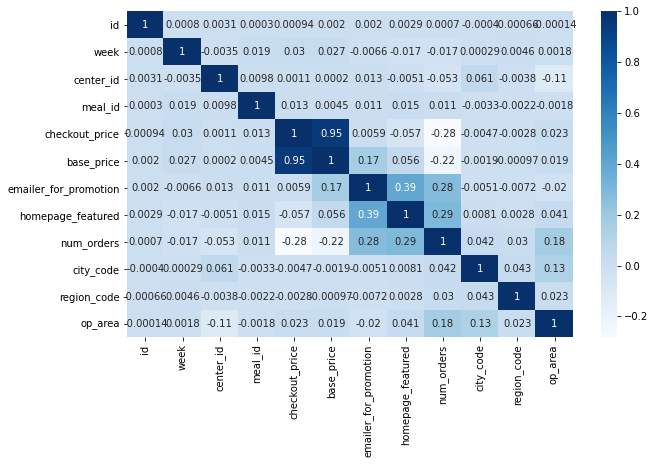

In [ ]:
MyChartHeatmap(df)

In [ ]:
df['Month'] = df['week'].apply(lambda x: int(x / 4))
df['Year'] = df['week'].apply(lambda x: int(x / 52))
df['Quarter'] = df['week'].apply(lambda x: int(x / 13))

In [ ]:
df = df.drop("id", axis=1)

In [ ]:
df = df.dropna(axis=0)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   center_id              456548 non-null  int64  
 2   meal_id                456548 non-null  int64  
 3   checkout_price         456548 non-null  float64
 4   base_price             456548 non-null  float64
 5   emailer_for_promotion  456548 non-null  int64  
 6   homepage_featured      456548 non-null  int64  
 7   num_orders             456548 non-null  float64
 8   city_code              456548 non-null  int64  
 9   region_code            456548 non-null  int64  
 10  center_type            456548 non-null  object 
 11  op_area                456548 non-null  float64
 12  category               456548 non-null  object 
 13  cuisine                456548 non-null  object 
 14  Month                  456548 non-nu

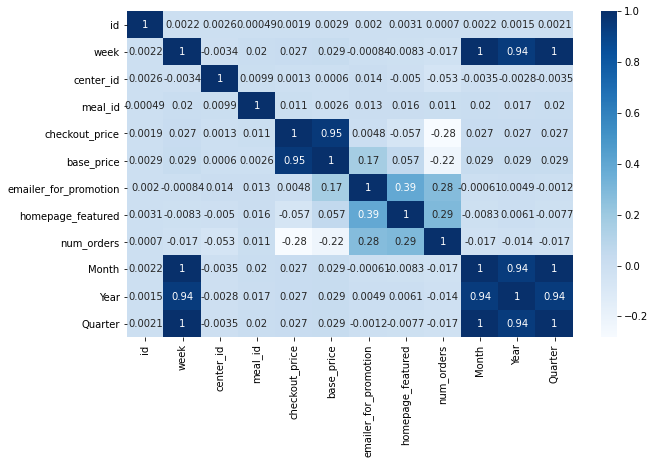

In [ ]:
MyChartHeatmap(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f91f956c6d8>,
      dtype=object)

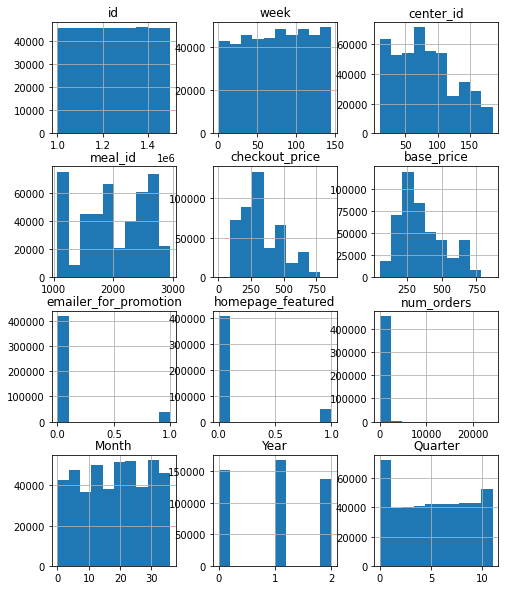

In [ ]:
df.hist(bins=10, figsize=(8,10))

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,456548.0,1.250096e+06,144354.822378,1000000.00,1124998.75,1250183.50,1375140.25,1499999.00
week,456548.0,7.476877e+01,41.524956,1.00,39.00,76.00,111.00,145.00
center_id,456548.0,8.210580e+01,45.975046,10.00,43.00,76.00,110.00,186.00
meal_id,456548.0,2.024337e+03,547.420920,1062.00,1558.00,1993.00,2539.00,2956.00
checkout_price,456548.0,3.322389e+02,152.939723,2.97,228.95,296.82,445.23,866.27
base_price,456548.0,3.541566e+02,160.715914,55.35,243.50,310.46,458.87,866.27
emailer_for_promotion,456548.0,8.115247e-02,0.273069,0.00,0.00,0.00,0.00,1.00
homepage_featured,456548.0,1.091999e-01,0.311890,0.00,0.00,0.00,0.00,1.00
num_orders,456548.0,2.618728e+02,395.922798,13.00,54.00,136.00,324.00,24299.00
Month,456548.0,1.831845e+01,10.388115,0.00,9.00,19.00,27.00,36.00


IndexError: ignored

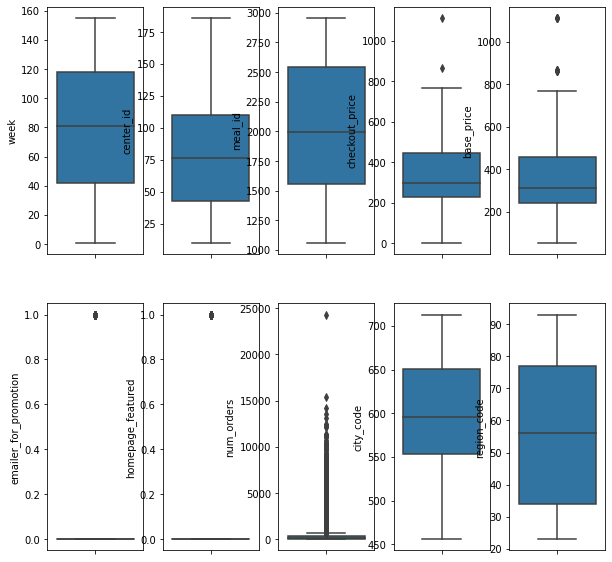

In [ ]:
MyPlots(df, "boxplot", ncols=5, nrows=2)

IndexError: ignored

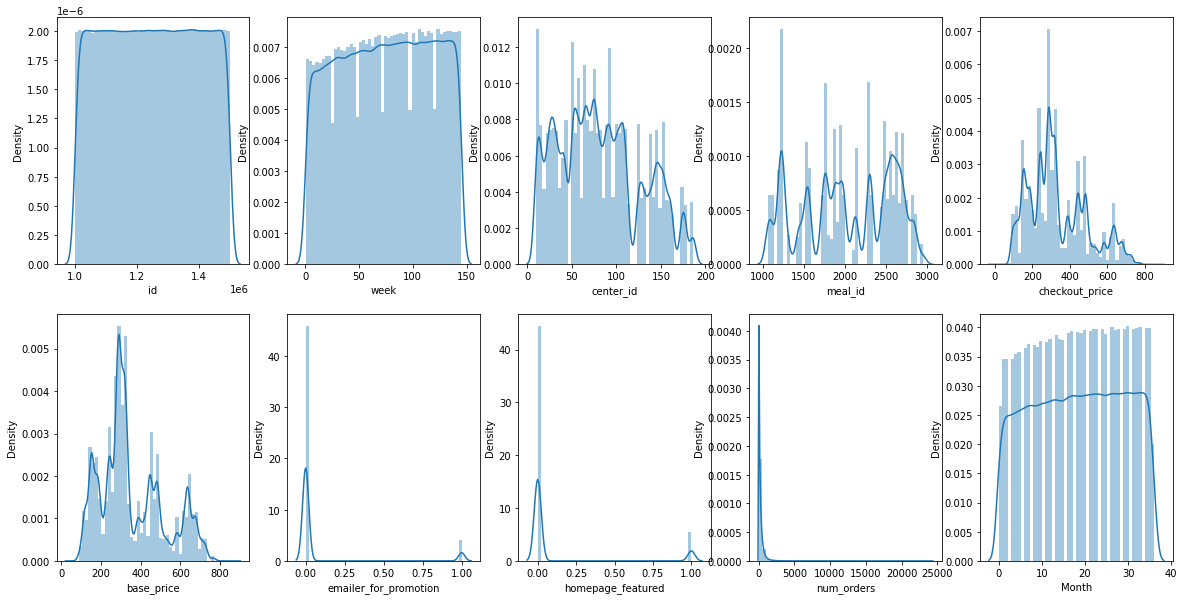

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   center_id              456548 non-null  int64  
 2   meal_id                456548 non-null  int64  
 3   checkout_price         456548 non-null  float64
 4   base_price             456548 non-null  float64
 5   emailer_for_promotion  456548 non-null  int64  
 6   homepage_featured      456548 non-null  int64  
 7   num_orders             456548 non-null  float64
 8   city_code              456548 non-null  int64  
 9   region_code            456548 non-null  int64  
 10  center_type            456548 non-null  object 
 11  op_area                456548 non-null  float64
 12  category               456548 non-null  object 
 13  cuisine                456548 non-null  object 
 14  Month                  456548 non-nu

In [ ]:
df["category"].value_counts()

Beverages       127890
Rice Bowl        33408
Sandwich         33291
Pizza            33138
Starters         29941
Other Snacks     29379
Desert           29294
Salad            28559
Pasta            27694
Seafood          26916
Biryani          20614
Extras           13562
Soup             12675
Fish             10187
Name: category, dtype: int64

In [ ]:
df["category"].value_counts().sort_index()

def category_drop(category):
  if   category <= 'Beverages': cate = 0
  elif category <= 'Rice Bowl': cate = 1
  elif category <= 'Sandwich': cate = 2
  elif category <= 'Pizza':    cate = 3
  elif category <= 'Starters': cate = 4
  elif category <= 'Other Snacks': cate = 5
  elif category <= 'Desert': cate = 6
  elif category <= 'Salad': cate = 7
  elif category <= 'Pasta': cate = 8
  elif category <= 'Seafood': cate = 9
  elif category <= 'Biryani': cate = 10
  elif category <= 'Extras': cate = 11
  elif category <= 'Soup': cate = 12
  else:           cate = 13
  return cate

df["category_cate"] = df["category"].apply(lambda x: category_drop(x))
df["category_cate"].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   center_id              456548 non-null  int64  
 2   meal_id                456548 non-null  int64  
 3   checkout_price         456548 non-null  float64
 4   base_price             456548 non-null  float64
 5   emailer_for_promotion  456548 non-null  int64  
 6   homepage_featured      456548 non-null  int64  
 7   num_orders             456548 non-null  float64
 8   city_code              456548 non-null  int64  
 9   region_code            456548 non-null  int64  
 10  center_type            456548 non-null  object 
 11  op_area                456548 non-null  float64
 12  category               456548 non-null  object 
 13  cuisine                456548 non-null  object 
 14  Month                  456548 non-nu

In [ ]:
# #-----------------------------------------
# X["Age_cate"] = X["Age"].apply(lambda x : int(x//10))#해당하는 나이는 나이 구간으로 집어넣음, 몫으로 가지고 옴
# X = pd.get_dummies(data=X , columns=["Age_cate"], prefix = "OH_Age_cate") #drop.first=True : 원본을 지워버림
# print(X.info())

In [ ]:
df['center_type'].value_counts()

TYPE_A    262881
TYPE_C     99593
TYPE_B     94074
Name: center_type, dtype: int64

In [ ]:
df["center_type"].value_counts().sort_index()

def center_type_drop(center_type):
  if   center_type <= 'TYPE_A': cate = 0
  elif center_type <= 'TYPE_B': cate = 1
  else:           cate = 2
  return cate

df["center_type_cate"] = df["center_type"].apply(lambda x: center_type_drop(x))
df["center_type_cate"].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   center_id              456548 non-null  int64  
 2   meal_id                456548 non-null  int64  
 3   checkout_price         456548 non-null  float64
 4   base_price             456548 non-null  float64
 5   emailer_for_promotion  456548 non-null  int64  
 6   homepage_featured      456548 non-null  int64  
 7   num_orders             456548 non-null  float64
 8   city_code              456548 non-null  int64  
 9   region_code            456548 non-null  int64  
 10  center_type            456548 non-null  object 
 11  op_area                456548 non-null  float64
 12  category               456548 non-null  object 
 13  cuisine                456548 non-null  object 
 14  Month                  456548 non-nu

In [ ]:
df['cuisine'].value_counts()

Italian        122925
Thai           118216
Indian         112612
Continental    102795
Name: cuisine, dtype: int64

In [ ]:
df["cuisine"].value_counts().sort_index()

def cuisine_drop(cuisine):
  if   cuisine <= 'Italian': cate = 0
  elif cuisine <= 'Thai': cate = 1
  elif cuisine <= 'Indian': cate = 2
  else:           cate = 3
  return cate

df["cuisine_cate"] = df["cuisine"].apply(lambda x: center_type_drop(x))
df["cuisine_cate"].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   center_id              456548 non-null  int64  
 2   meal_id                456548 non-null  int64  
 3   checkout_price         456548 non-null  float64
 4   base_price             456548 non-null  float64
 5   emailer_for_promotion  456548 non-null  int64  
 6   homepage_featured      456548 non-null  int64  
 7   num_orders             456548 non-null  float64
 8   city_code              456548 non-null  int64  
 9   region_code            456548 non-null  int64  
 10  center_type            456548 non-null  object 
 11  op_area                456548 non-null  float64
 12  category               456548 non-null  object 
 13  cuisine                456548 non-null  object 
 14  Month                  456548 non-nu

In [ ]:
df = df.drop("center_type", axis=1)
df = df.drop("category", axis=1)
df = df.drop("cuisine", axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   center_id              456548 non-null  int64  
 2   meal_id                456548 non-null  int64  
 3   checkout_price         456548 non-null  float64
 4   base_price             456548 non-null  float64
 5   emailer_for_promotion  456548 non-null  int64  
 6   homepage_featured      456548 non-null  int64  
 7   num_orders             456548 non-null  float64
 8   city_code              456548 non-null  int64  
 9   region_code            456548 non-null  int64  
 10  op_area                456548 non-null  float64
 11  Month                  456548 non-null  int64  
 12  Year                   456548 non-null  int64  
 13  Quarter                456548 non-null  int64  
 14  category_cate          456548 non-nu

In [ ]:
y = df["num_orders"] #타겟데이터 꺼내기
X = df.drop("num_orders", axis=1) #잘라낸것을 X에 대입
print(X.shape, y.shape)#잘 잘라냈는지 확인

(456548, 16) (456548,)


In [ ]:
def GET_MY_SCORE(y_test, pred, str=None) :
    print("-----------{}------------".format(str))
    X_train, X_test, y_train , y_test = train_test_split(X,y, test_size = 0.2, random_state=121)
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train) # 학습해서 메모리에 올려놔라. 아직 리턴값은 없음.
    pred = rf_model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred) 
    rocauc = roc_auc_score(y_test, pred)
    #print("정확도:", acc, "f1:",f1 )
    print("정확도: {:.4f} F1: {:.4f} (정밀도: {:.4f} 재현율: {:.4f}) rocauc:{:.4f} ".format(acc, f1, precision, recall, rocauc))
    print(acc) # f는 자연수를 의미. 소수점 4자리까지 자연수로 보여달라 이런 의미
    cf_matrix = confusion_matrix(y_test, pred)
    print(cf_matrix) 

In [ ]:
train = df.iloc[ :456548, :]
test =  df.iloc[456548:, :]

# print(train.shape , test.shape)

y_train = train["num_orders"]                             # 학습용 답안
X_train = train.drop("num_orders", axis=1)                # 학습용 답안
test = test.drop("num_orders", axis=1)  #, inplace=True)  # 시험용 문제
print(y_train.shape , X_train.shape, test.shape)

(456548,) (456548, 16) (0, 16)


In [ ]:
rf_model = RandomForestClassifier()
MySplitFitPredict(rf_model, X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1, random_state=0, min_samples_leaf=30)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
scaler   = RobustScaler()

X_scaler = scaler.fit_transform(X_train)

In [ ]:
my_hyper_param = {  "n_estimators"     :[100, 300],
                    "max_depth"        :[4, 5, 6],
                    "min_samples_leaf" :[2, 3, 4],
                    "random_state"     :[121,]    }

def MyGridSearchCV(my_hyper_param, model, X, y) :
    print("GridSerchCV --------------------------------")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121)
    my_score  = {"acc": "accuracy", "f1": "f1"}
    gcv_model = GridSearchCV(model, param_grid=my_hyper_param, scoring=my_score, refit="f1", cv=5, verbose=0)
    gcv_model.fit(X_train, y_train)

    # print("best_estimator:", gcv_model.best_estimator_)
    print("best_params :", gcv_model.best_params_)
    print("best_score  :", gcv_model.best_score_)
    print("GridSearchCV 평균 정확도 : ", gcv_model.cv_results_["mean_test_acc"].mean())  #mean_test_(본인의score키값)
    print("GridSearchCV 평균 F1    : ", gcv_model.cv_results_["mean_test_f1"].mean())
    print(barline)

MyGridSearchCV(my_hyper_param, model, X_scaler, y_train)

GridSerchCV --------------------------------


ValueError: ignored

In [ ]:
from sklearn.linear_model import SGDRegressor

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy
import os
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential()
#model.add(LSTM(32, input_shape=(600,6)))
model.add(Dense(30,  input_dim=16, activation='relu')) #input_dim 칼럼
model.add(Dense(20, activation='relu'))
model.add(Dense(12, kernel_initializer='normal', activation='relu'))
Dropout(0.25)
model.add(Dense(8, activation='relu'))
model.add(Dense(61)

# LSTM: (3125, 600, 6) -> 600개씩 feature 6개를 잘라
# Dense: (3125*600, 6)  -> 6개 feature: 3125개


model.compile(loss='binary_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 저장 폴더 만들기
# MODEL_DIR = 'content/MyDrive/Colab Notebooks/dacon/model/'
# if not os.path.exists(MODEL_DIR):
#    os.mkdir(MODEL_DIR)

modelpath="content/MyDrive/Colab Notebooks/dacon/model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=100)

# model.fit(X, y, validation_split=0.2, epochs=3500, batch_size=500, verbose=0, callbacks=[early_stopping_callback,checkpointer])
model.fit(X,y, epochs=3000, batch_size=128, validation_split=0.2, verbose=0, callbacks=[early_stopping_callback,checkpointer])
# model.fit(X,y, epochs=30, batch_size=128, validation_split=0.2)   # leaderboard

SyntaxError: ignored

In [ ]:
X_train, X_test, y_train , y_test = train_test_split(X,y, test_size = 0.2, random_state=121)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train) # 학습해서 메모리에 올려놔라. 아직 리턴값은 없음.
pred = rf_model.predict(X_test)

acc = accuracy_score(y_test, pred)
f1 = f1_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred) 
rocauc = roc_auc_score(y_test, pred)
#print("정확도:", acc, "f1:",f1 )
print("정확도: {:.4f} F1: {:.4f} (정밀도: {:.4f} 재현율: {:.4f}) rocauc:{:.4f} ".format(acc, f1, precision, recall, rocauc))
print(acc) # f는 자연수를 의미. 소수점 4자리까지 자연수로 보여달라 이런 의미
cf_matrix = confusion_matrix(y_test, pred)
print(cf_matrix) # 여기서 (1,2)위치는 정밀도(FP) : 예측이 당뇨(P)인데 실제로는 정상(N)

KeyboardInterrupt: ignored

In [ ]:
model = Sequential()
model.add(LSTM(32, input_shape=(600,6)))
# model.add(Dense(30,  input_dim=24, activation='relu'))
model.add(Dense(20, activation='relu'))
Dropout(0.25)
model.add(Dense(12, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(61, activation='softmax'))

model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

# 모델 업데이트 및 저장
modelpath="content/MyDrive/Colab Notebooks/dacon/model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

# 학습 자동 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=100)

model.fit(X_scaled,y, epochs=3000, batch_size=128, validation_split=0.2, verbose=0, callbacks=[early_stopping_callback,checkpointer])

NameError: ignored

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   week                   456548 non-null  int64  
 1   center_id              456548 non-null  int64  
 2   meal_id                456548 non-null  int64  
 3   checkout_price         456548 non-null  float64
 4   base_price             456548 non-null  float64
 5   emailer_for_promotion  456548 non-null  int64  
 6   homepage_featured      456548 non-null  int64  
 7   num_orders             456548 non-null  float64
 8   city_code              456548 non-null  int64  
 9   region_code            456548 non-null  int64  
 10  op_area                456548 non-null  float64
 11  Month                  456548 non-null  int64  
 12  Year                   456548 non-null  int64  
 13  Quarter                456548 non-null  int64  
 14  category_cate          456548 non-nu

In [ ]:
#전처리 전의 점수(전처리 후의 점수와 비교하기 위함)
X_train ,X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121) #random_state=121 : 헷갈리면 안되기에 아무 수치나
#문제 문제 8:2, 답안 답안 8:2
rf_model = RandomForestClassifier() #모델을 다른것 사용하려면 이 한 줄만 바꾸면 됨
rf_model.fit(X_train, y_train)#fit: 해당 모델을 이용해서 학습해라, 완료시 return데이터는 없음, X_train, y_train : 문제와 답안
pred = rf_model.predict(X_test) #X_test 시험지를 주고 맞추라는 의미
GET_MY_SCORE(y_test, pred, "최초점수") #확인했으나 그닥 마음에 드는 점수가 아님

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs=-1, random_state=0, min_samples_leaf=30)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
scaler   = RobustScaler()

X_scaler = scaler.fit_transform(X_train)

In [ ]:
my_hyper_param = {  "n_estimators"     :[100, 300],
                    "max_depth"        :[4, 5, 6],
                    "min_samples_leaf" :[2, 3, 4],
                    "random_state"     :[121,]    }

def MyGridSearchCV(my_hyper_param, model, X, y) :
    print("GridSerchCV --------------------------------")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121)
    my_score  = {"acc": "accuracy", "f1": "f1"}
    gcv_model = GridSearchCV(model, param_grid=my_hyper_param, scoring=my_score, refit="f1", cv=5, verbose=0)
    gcv_model.fit(X_train, y_train)

    # print("best_estimator:", gcv_model.best_estimator_)
    print("best_params :", gcv_model.best_params_)
    print("best_score  :", gcv_model.best_score_)
    print("GridSearchCV 평균 정확도 : ", gcv_model.cv_results_["mean_test_acc"].mean())  #mean_test_(본인의score키값)
    print("GridSearchCV 평균 F1    : ", gcv_model.cv_results_["mean_test_f1"].mean())
    print(barline)

MyGridSearchCV(my_hyper_param, model, X_scaler, y_train)

GridSerchCV --------------------------------


ValueError: ignored